<a href="https://colab.research.google.com/github/VSPlekhanov/TimeSeriesForecasting_analysis/blob/main/Contact_center_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [ ]:
%%time
# get Divvy Bicycle Sharing data and modify it 
data = pd.read_csv('drive/MyDrive/Diploma/data/data_raw.csv')

data = data.drop(columns=['from_station_id', 'from_station_name', \
                          'to_station_id', 'to_station_name', 'latitude_start',\
                          'longitude_start', 'latitude_end', 'latitude_end', \
                          'longitude_end', 'trip_id', 'usertype', 'stoptime',\
                          'tripduration', 'dpcapacity_start', 'dpcapacity_end',\
                          'gender'], axis=1) 

data['yr'] = data.starttime.apply(func=lambda x: re.split('[-: ]', x)[0])
data['mo'] = data.starttime.apply(func=lambda x: re.split('[-: ]', x)[1])
data['day'] = data.starttime.apply(func=lambda x: re.split('[-: ]', x)[2])
data['hr'] = data.starttime.apply(func=lambda x: re.split('[-: ]', x)[3])

data = data.groupby(['yr', 'mo', 'day', 'hr'], as_index=False).agg({'starttime': 'count', 'temperature': 'min', 'windchill': 'min', 'dewpoint': 'min',\
          'humidity': 'min', 'pressure': 'min', 'visibility': 'min', 'wind_speed': 'min',\
          'precipitation': 'min', 'events': 'min', 'rain': 'min', 'conditions': 'min'})\
            .rename({'starttime': 'y'}, axis=1)

In [3]:
# get weather data and modify it
humidity = pd.read_csv('drive/MyDrive/Diploma/data/weather/humidity.csv')
pressure = pd.read_csv('drive/MyDrive/Diploma/data/weather/pressure.csv')
temperature = pd.read_csv('drive/MyDrive/Diploma/data/weather/temperature.csv')
weather_description = pd.read_csv('drive/MyDrive/Diploma/data/weather/weather_description.csv')
wind_direction = pd.read_csv('drive/MyDrive/Diploma/data/weather/wind_direction.csv')
wind_speed = pd.read_csv('drive/MyDrive/Diploma/data/weather/wind_speed.csv')

weather = pd.DataFrame()
weather['datetime'] = humidity.datetime
weather['humidity'] = humidity.Chicago
weather['pressure'] = pressure.Chicago
weather['temperature'] = temperature.Chicago
weather['weather_description'] = weather_description.Chicago
weather['wind_direction'] = wind_direction.Chicago
weather['wind_speed'] = wind_speed.Chicago

weather = weather.drop(np.arange(0,6400))

weather['yr'] = weather.datetime.apply(func=lambda x: re.split('[-: ]', x)[0])
weather['mo'] = weather.datetime.apply(func=lambda x: re.split('[-: ]', x)[1])
weather['day'] = weather.datetime.apply(func=lambda x: re.split('[-: ]', x)[2])
weather['hr'] = weather.datetime.apply(func=lambda x: re.split('[-: ]', x)[3])

In [4]:
# merge those 2 datasets
all_data = data.merge(weather, 'inner', on=['yr', 'mo', 'day', 'hr'], suffixes=('_1', '_2'))

In [5]:
# calculate working and non-working days
holidays_set = {
    '04-07-2013',
    '02-09-2013','14-10-2013','11-11-2013','28-11-2013','25-12-2013',
    '01-01-2014','20-01-2014','17-02-2014','26-03-2014','04-07-2014',
    '01-09-2014','13-10-2014','11-11-2014','27-11-2014','25-12-2014',
    '01-01-2015','19-01-2015','16-02-2015','25-03-2015','03-07-2015',
    '07-09-2015','12-10-2015','11-11-2015','26-11-2015','25-12-2015',
    '01-01-2016','18-01-2016','15-02-2016','30-03-2016','04-07-2016',
    '05-09-2016','10-10-2016','11-11-2016','24-11-2016','26-12-2016',
    '02-01-2017','16-01-2017','20-02-2017','29-03-2017','04-07-2017',
    '04-09-2017','09-10-2017','10-11-2017','23-11-2017','25-12-2017',
}

month_days_count = \
{0:0, 1:31, 2:59, 3:90, 4:120, 5:151, 6:181, 7:212, 8:243, 9:273, 10:304, 11:334}

week = \
{0: 'workday', 1: 'workday', 2: 'workday', 3: 'workday', 4: 'weekend', 5:'weekend', 6: 'workday'}

def day_type_calculation(row):
    date = f'{row["day"]}-{row["mo"]}-{row["yr"]}'
    if date in holidays_set:
        return 'holiday'
    days, mo, yr = int(row['day']), int(row['mo']), int(row['yr'])
    mdays = month_days_count[mo - 1]
    if yr % 4 == 0 and mo > 2: mdays += 1    
    day_of_week = (int((yr - 2013) * 365.25) + mdays + days - 1) % 7
    return week[day_of_week] 

all_data['day_type'] = all_data.apply(lambda x: day_type_calculation(x), axis=1)

In [6]:
# get rid of nans
all_data['humidity_2'] = all_data.apply(lambda x: \
                                        x['humidity_1'] if np.isnan(x['humidity_2'])\
                                        else x['humidity_2'], axis=1)
all_data['pressure_2'] = all_data.apply(lambda x: \
                                        x['pressure_1'] if np.isnan(x['pressure_2'])\
                                        else x['pressure_2'], axis=1)
all_data['humidity_1'] = all_data.apply(lambda x: \
                                        x['humidity_2'] if np.isnan(x['humidity_1'])\
                                        else x['humidity_1'], axis=1)
all_data['temperature_1'] = all_data.apply(lambda x: \
                                        x['temperature_1'] if x['temperature_1'] > -50\
                                        else x['temperature_2'], axis=1)

In [7]:
# amend all non-numeric values with numbers, deal with strange values
all_data.loc[all_data['windchill'] < 0, 'windchill'] = 0
all_data.loc[all_data['precipitation'] < 0, 'precipitation'] = 0

events = {'clear': 0, 'partlycloudy': 1, 'mostlycloudy': 2, 'cloudy': 3, 'fog': 4, 
          'hazy': 5,'snow': 6, 'sleet': 7, 'rain': 8, 'tstorms': 9, 'unknown': 10}
all_data['events'] = all_data['events'].apply(lambda x: events[x]) 

conditions = {
    'Clear': 0, 'Partly Cloudy': 1, 'Scattered Clouds': 2, 'Mostly Cloudy': 3, 'Overcast': 4,
    'Patches of Fog': 5, 'Shallow Fog': 6, 'Mist': 7, 'Light Freezing Fog': 8, 'Fog': 9, 
    'Haze': 10, 'Smoke': 11, 'Light Drizzle': 12, 'Light Freezing Drizzle': 13, 'Drizzle': 14, 
    'Light Hail': 15, 'Light Ice Pellets': 16, 'Ice Pellets': 17, 'Light Snow': 18, 'Snow': 19,
    'Heavy Snow': 20, 'Blowing Snow': 21, 'Thunderstorm': 22,
    'Light Thunderstorms with Hail': 23, 'Light Rain': 24, 'Light Freezing Rain': 25, 
    'Light Thunderstorms and Rain': 26, 'Rain': 27, 'Freezing Rain': 28,
    'Thunderstorms and Rain': 29, 'Heavy Rain': 30, 'Heavy Thunderstorms and Rain': 31,
    'Unknown': 32}
all_data['conditions'] = all_data['conditions'].apply(lambda x: conditions[x]) 

weather_description = {
    'thunderstorm': 0, 'mist': 1, 'thunderstorm with rain': 2, 'light rain': 3, 
    'moderate rain': 4, 'scattered clouds': 5, 'few clouds': 6, 'broken clouds': 7, 
    'overcast clouds': 8, 'sky is clear': 9, 'proximity thunderstorm': 10, 
    'thunderstorm with light rain': 11, 'haze': 12, 'heavy intensity rain': 13, 
    'thunderstorm with heavy rain': 14, 'light intensity drizzle': 15, 'very heavy rain': 16,
    'fog': 17, 'drizzle': 18, 'light snow': 19, 'heavy intensity drizzle': 20, 'snow': 21, 
    'thunderstorm with drizzle': 22, 'proximity thunderstorm with rain': 23, 'heavy snow': 24,
    'proximity thunderstorm with drizzle': 25, 'squalls': 26, 'freezing rain': 27, 
    'thunderstorm with light drizzle': 28, 'smoke': 29, 'dust': 30, 
    'proximity shower rain': 31}

all_data['weather_description'] = all_data['weather_description'].apply(lambda x: weather_description[x]) 

day_types = {'workday': 0, 'weekend': 1, 'holiday': 2}
all_data['day_type'] = all_data['day_type'].apply(lambda x: day_types[x]) 


In [ ]:
all_data = all_data.drop(['datetime'], axis=1)

In [401]:
daily_data = all_data.groupby(['yr', 'mo', 'day'], as_index=False).agg({'temperature_1': 'mean', 'windchill':'mean', 'dewpoint':'mean', 'humidity_1':'mean', \
                                                           'pressure_1':'mean', 'visibility':'mean', 'wind_speed_1':'mean', 'precipitation':'mean',\
                                                           'rain': 'max', 'humidity_2':'mean', 'pressure_2':'mean', 'temperature_2': 'mean', \
                                                           'wind_speed_2': 'mean', 'day_type': 'max', 'y':'sum'})

In [10]:
y = daily_data['y']
daily_data = daily_data.drop('y', axis=1)

In [11]:
y_train, y_test = train_test_split(y, shuffle=False)
x_train, x_test = train_test_split(daily_data,shuffle=False)

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(y, label='count')
plt.legend()

plt.show()

In [13]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(100).fit(x_train, y_train)
rf_predict = rf.predict(x_test)

In [ ]:
math.sqrt(mean_squared_error(y_test.values, rf_predict))

In [15]:
def get_fi_plot(fi):
    feature_importances_df = pd.DataFrame({'features':list(x_train.columns), 
                                       'feature_importances':  fi})\
                        .sort_values(by='feature_importances')

    f, ax = plt.subplots(figsize=(6, 6))
    sns.barplot(y=feature_importances_df.features, x=feature_importances_df.feature_importances)

    plt.xlabel('Важность атрибутов')
    plt.ylabel('Атрибуты')
    plt.title("Наиболее важные атрибуты")
    plt.show()

In [ ]:
get_fi_plot(rf.feature_importances_)

In [17]:
daily_data = daily_data.drop(['temperature_2', 'dewpoint', 'day', 'windchill', 'wind_speed_2', 'pressure_2', 'humidity_2', 'visibility', 'pressure_1', 'precipitation', 'wind_speed_1', 'mo', 'humidity_1'], axis=1)
daily_data = daily_data.drop(['rain', 'day_type'], axis=1)

In [18]:
y_train, y_test = train_test_split(y, shuffle=False)
x_train, x_test = train_test_split(daily_data,shuffle=False)

In [ ]:
# Тест Дики-Фулера
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(y)
print("pvalue = ", pvalue, " если больще 0.05, временной ряд не стацонарен")

In [19]:
data = daily_data
y = pd.DataFrame(y)
y = y.set_index(pd.date_range("2013-06-27", periods=1615, freq="D"))

In [20]:
size = int(len(data) * 0.66)
X_train, X_test = data[:size], data[size:len(data)]
y_train, y_test = y[:size], y[size:len(y)]

In [21]:
s = 364
prediction = y.copy()
for i in range(len(y_test)):
  prev = prediction['y'][len(y_train) + i - s]
  prediction['y'][len(y_train) + i] = prev

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y, label='Данные', color='blue')
plt.plot(prediction[len(X_train):], label='Прогноз', color='red')
plt.legend()
testScore = math.sqrt(mean_squared_error(y_test, prediction[len(y_train):]))
print('Корень среднеквадратичного отклонения на проверяющей выборке: %.2f' % (testScore))

In [22]:
def predict_full(model, data, start=len(y_train)):
  model = model.fit()
  pred = model.predict(start=start, end=len(data)-1)

  return pred

In [23]:
def predict_window(modelCreationFunc, data, window, start=len(y_train)):
  curr_start = start
  pred = pd.Series(dtype='float64')
  while curr_start < len(data):
    model = modelCreationFunc(data[:curr_start])
    model = model.fit()
    pred = pred.append(model.predict(start=curr_start, end=min(curr_start + window - 1, len(data) - 1)))
    curr_start += window

  return pred

In [24]:
def analyse(full, mid, low):
  testScore = math.sqrt(mean_squared_error(y_test, full))
  print('Корень среднеквадратичного отклонения при полном прогнозе: %.2f' % (testScore))

  testScore = math.sqrt(mean_squared_error(y_test, mid))
  print('Корень среднеквадратичного отклонения при прогнозе на год: %.2f' % (testScore))

  testScore = math.sqrt(mean_squared_error(y_test, low))
  print('Корень среднеквадратичного отклонения при прогнозе на месяц: %.2f' % (testScore))

  fig, ax = plt.subplots(nrows=2, ncols=2)
  fig.set_figheight(12)
  fig.set_figwidth(15)

  ax[0][0].plot(y_test, label='Данные', color='blue')
  ax[0][0].plot(full, label='Прогноз на весь промежуток', color='red')
  ax[0][0].plot(mid, label='Прогноз на год', color='green')
  ax[0][0].plot(low, label='Прогноз на месяц', color='purple')
  ax[0][0].legend(loc='best');

  ax[0][1].plot(y_test, label='Данные', color='blue')
  ax[0][1].plot(full, label='Прогноз на весь промежуток', color='red')
  ax[0][1].legend(loc='best');

  ax[1][0].plot(y_test, label='Данные', color='blue')
  ax[1][0].plot(mid, label='Прогноз на год', color='green')
  ax[1][0].legend(loc='best');

  ax[1][1].plot(y_test, label='Данные', color='blue')
  ax[1][1].plot(low, label='Прогноз на месяц', color='purple')
  ax[1][1].legend(loc='best');

In [25]:
def get_ES_model(train):
  return ExponentialSmoothing(train, seasonal='add', seasonal_periods=364, freq='D')

In [ ]:
%%time
from statsmodels.tsa.holtwinters import ExponentialSmoothing

full = predict_full(get_ES_model(y_train), y)
mid = predict_window(get_ES_model, y, 120)
low = predict_window(get_ES_model, y, 14)

analyse(full, mid, low)

In [26]:
year = data['yr'].values.astype('int').reshape(len(data), 1)
temp = data['temperature_1'].values.reshape(len(data), 1)
exog = np.concatenate((year, temp), axis=1)

In [196]:
def get_ARIMA(data, ex):
  return SARIMAX(endog=data['y'], order=(1,0,1),\
                 seasonal_order=(0,0,0,0),\
                 exog=ex,\
                 freq='D')

In [197]:
def predict_window_ARIMA(modelCreationFunc, data, window, start=len(X_train), exog=[]):
  curr_start = start
  pred = pd.Series(dtype='float64')
  while curr_start < len(data):
    end = min(curr_start + window - 1, len(data) - 1)
    model = modelCreationFunc(data[:curr_start], exog[:curr_start])
    model = model.fit()
    p = model.predict(start=curr_start, end=end, exog=exog[curr_start:end+1])
    pred = pred.append(p)
    curr_start += window

  return pred

In [198]:
def predict_full_ARIMA(model, data, start=len(X_train), exog=[]):
  model = model.fit(iprint=0)
  pred = model.predict(start=start, end=len(data)-1, exog=exog)

  return pred

In [ ]:
%%time
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = get_ARIMA(y_train, exog[:len(X_train)])
full = predict_full_ARIMA(model, y, exog=exog[len(X_train):])
mid = predict_window_ARIMA(get_ARIMA, y, 120, exog=exog)
low = predict_window_ARIMA(get_ARIMA, y, 14, exog=exog)
analyse(full, mid, low)

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow import random

np.random.seed(1)
random.set_seed(2)

In [125]:
dataset = y.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [ ]:
datasetX = daily_data.copy()
datasetX = scaler.fit_transform(datasetX)

In [63]:
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

In [69]:
all_dataset = np.concatenate((datasetX, dataset), axis=1)

In [283]:
def predict_full_train(get_model, trainX, trainY, testX, testY):
  model = get_model()
  model.fit(trainX, trainY, verbose=0, epochs=300, validation_data=(testX, testY))
  pred = model.predict(trainX)

  trainPredict = scaler.inverse_transform(pred)
  trainY_inverse = scaler.inverse_transform([trainY])

  trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))

  return trainScore
  # return pred

In [ ]:
%%time
predict_full_train(get_FFNN_model, trainX, trainY, testX, testY)

In [285]:
def predict_full(func, trainX, trainY, testX, testY, count, epochs=100):
  pred = np.zeros((len(testY), 1))
  for i in range(count):
    model = func()
    model.fit(trainX, trainY, verbose=0, epochs=epochs)
    pred += model.predict(testX)

  testPredict = pred / count
  testPredict = scaler.inverse_transform(testPredict)
  testY_inverse = scaler.inverse_transform([testY])

  testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
  return testPredict, testScore

In [286]:
def predict_parts(model, trainX, trainY, testX, testY, window, epochs):
  dataX = np.concatenate((trainX, testX))
  dataY = np.concatenate((trainY, testY))

  parts_count = int(len(testY) / window)
  parts = []
  for i in range(parts_count):
    parts += [testX[i * window:(i + 1) * window]]
  if parts_count * window < len(testX):
    parts += [testX[parts_count * window:]]
  
  pred = np.empty((0, 1))

  for i in range(len(parts)):
    curr_len = len(trainX) + window * i
    prev_len = 0
    
    model.fit(dataX[prev_len:curr_len], dataY[prev_len:curr_len], verbose=0, epochs=epochs)
    pred = np.concatenate(\
        (pred, model.predict(dataX[curr_len:curr_len + min(window, len(dataX) - curr_len)])))
    prev_len = curr_len
  testPredict = scaler.inverse_transform(pred)
  testY_inverse = scaler.inverse_transform([testY])

  testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
  return testPredict, testScore

In [176]:
trainDF = y[:train_size]
testDF = y[train_size:]

In [321]:
seq_len = 18
trainX, testX, trainY, testY = [], [], [], []
for i in range(train_size - seq_len):
  trainX.append(train[i:i + seq_len, 0])
  trainY.append(train[i+seq_len, 0])

for i in range(test_size):
  testX.append(dataset[train_size + i - seq_len: train_size + i, 0])
  testY.append(test[i, 0])

trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)

In [322]:
def get_FFNN_model():
  model = Sequential()
  model.add(Dense(512, input_dim=seq_len, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(1))
  print(model.output_shape)  
  model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
  return model

In [ ]:
%%time
pred = predict_parts(get_FFNN_model(), trainX, trainY, testX, testY, 120, 500)[0]
pred_full, score = predict_full(get_FFNN_model, trainX, trainY, testX, testY, 1, 1000)
pred_low, score = predict_parts(get_FFNN_model(), trainX, trainY, testX, testY, 14, 200)

In [ ]:
analyse(pd.DataFrame(pred_full, index=testDF.index),
        pd.DataFrame(pred_full, index=testDF.index),
        pd.DataFrame(pred_full, index=testDF.index))

In [ ]:
analyse(pd.DataFrame(pred_full, index=testDF.index),
        pd.DataFrame(pred, index=testDF.index),
        pd.DataFrame(pred_low, index=testDF.index))

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(testDF[:100], lw=4)
plt.plot(pd.DataFrame(pred_low, index=testDF.index)[:100], color='red', lw=4)

In [257]:
seq_len = 20
trainX, trainY = [], []
for i in range(seq_len, train_size):
  trainX.append(all_dataset[i - seq_len:i,:])
  trainY.append(dataset[i])

testX, testY = [], []
for i in range(train_size, len(dataset)):
  testX.append(all_dataset[i - seq_len:i,:])
  testY.append(dataset[i])

trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)

In [235]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import random

np.random.seed(1)
random.set_seed(2)
num_features = 1

In [236]:
def get_RNN_model():
  print('get model')
  model = Sequential()
  model.add(SimpleRNN(150, input_shape=trainX.shape[1:], activation='relu', return_sequences=True)) #12
  model.add(SimpleRNN(150, activation='relu')) #12
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc']) 
  return model

In [255]:
def predict_full_train(get_model, trainX, trainY, testX, testY):
  model = get_model()
  model.fit(trainX, trainY, verbose=0, epochs=100, validation_data=(testX, testY))
  pred = model.predict(trainX)

  trainPredict = scaler.inverse_transform(pred)
  trainY_inverse = scaler.inverse_transform(trainY)

  trainScore = math.sqrt(mean_squared_error(trainY_inverse[:,0], trainPredict[:,0]))

  return trainScore

In [ ]:
%%time
predict_full_train(get_RNN_model, trainX, trainY, testX, testY)

In [197]:
trainPredict = scaler.inverse_transform(pred)
trainY_inverse = scaler.inverse_transform(trainY)

In [331]:
def predict_full(func, trainX, trainY, testX, testY, count, epochs=100):
  pred = np.zeros((len(testY), 1))
  for i in range(count):
    model = func()
    model.fit(trainX, trainY, verbose=0, epochs=epochs)
    pred += model.predict(testX)

  testPredict = pred / count
  testPredict = scaler.inverse_transform(testPredict)
  testY_inverse = scaler.inverse_transform(testY)

  testScore = math.sqrt(mean_squared_error(testY_inverse[:,0], testPredict[:,0]))
  return testPredict, testScore

In [ ]:
%%time
pred = predict_parts(get_FFNN_model(), trainX, trainY, testX, testY, 120, 200)[0]
pred_full, score = predict_full(get_RNN_model, trainX, trainY, testX, testY, 1, 300)
pred_low, score = predict_parts(get_FFNN_model(), trainX, trainY, testX, testY, 14, 50)

Корень среднеквадратичного отклонения при полном прогнозе: 2926.53
Корень среднеквадратичного отклонения при прогнозе на год: 2900.44
Корень среднеквадратичного отклонения при прогнозе на месяц: 2891.84


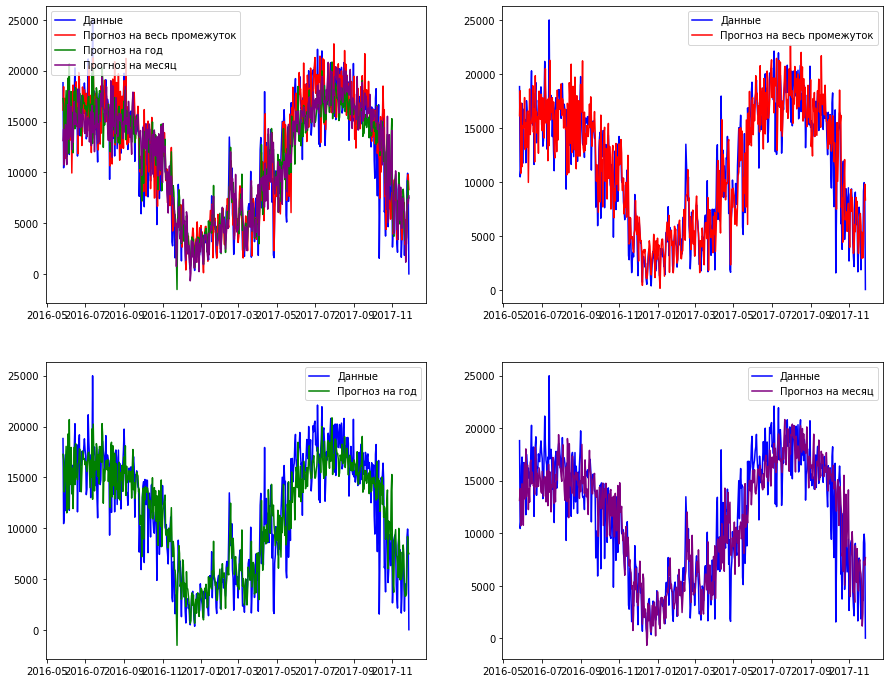

In [249]:
analyse(pd.DataFrame(pred_full, index=testDF.index),
        pd.DataFrame(pred, index=testDF.index),
        pd.DataFrame(pred_low, index=testDF.index))

In [344]:
def get_LSTM_model():
  model = Sequential()
  model.add(LSTM(64, input_shape=testX.shape[1:],activation='relu', return_sequences=True))
  model.add(LSTM(32,activation='relu'))
  model.add(Dense(64))
  model.add(Dense(64))
  model.add(Dense(1))
  model.compile(optimizer = 'adam', loss='mse')
  return model

In [345]:
seq_len = 18
trainX, trainY = [], []
for i in range(seq_len, train_size):
  trainX.append(all_dataset[i - seq_len:i,:])
  trainY.append(dataset[i])

testX, testY = [], []
for i in range(train_size, len(dataset)):
  testX.append(all_dataset[i - seq_len:i,:])
  testY.append(dataset[i])

trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)

In [ ]:
predict_full_train(get_LSTM_model, trainX, trainY, testX, testY)

In [ ]:
%%time
pred = predict_parts(get_FFNN_model(), trainX, trainY, testX, testY, 120, 200)[0]
pred_full, score = predict_full(get_LSTM_model, trainX, trainY, testX, testY, 1, 700)
pred_low, score = predict_parts(get_FFNN_model(), trainX, trainY, testX, testY, 14, 50)

In [ ]:
analyse(pd.DataFrame(pred_full, index=testDF.index),
        pd.DataFrame(pred_low, index=testDF.index),
        pd.DataFrame(pred, index=testDF.index))

In [496]:
seq_len = 20
train_X, test_X = [], []
for i in range(train_size - seq_len):
  train_X.append(train[i:i + seq_len, 0])

for i in range(test_size):
  test_X.append(dataset[train_size + i - seq_len: train_size + i, 0])

In [497]:
trainX = daily_data[seq_len:train_size].drop(['y'], axis=1)
trainY = y.values[seq_len:train_size]
testX = daily_data[train_size:].drop(['y'], axis=1)
testY = y.values[train_size:]

In [498]:
for i in range(seq_len):
  trainX['prev_' + str(i)] = pd.Series([arr[i] for arr in train_X], index=trainX.index)

In [499]:
for i in range(seq_len):
  testX['prev_' + str(i)] = pd.Series([arr[i] for arr in test_X], index=testX.index)

In [500]:
def predict_full_RF(model, trainX, trainY, testX, testY):
  model.fit(trainX, trainY)
  pred = model.predict(testX)
  testScore = math.sqrt(mean_squared_error(testY, pred))
  return pred, testScore

In [501]:
def predict_parts_RF(model, trainX, trainY, testX, testY, window):
  dataX = np.concatenate((trainX, testX))
  dataY = np.concatenate((trainY, testY))

  parts_count = int(len(testY) / window)
  parts = []
  for i in range(parts_count):
    parts += [testX[i * window:(i + 1) * window]]
  if parts_count * window < len(testX):
    parts += [testX[parts_count * window:]]
  
  pred = np.empty((0))

  for i in range(len(parts)):
    curr_len = len(trainX) + window * i
    prev_len = 0
    model.fit(dataX[prev_len:curr_len], dataY[prev_len:curr_len])
    pred = np.concatenate(\
        (pred, model.predict(dataX[curr_len:curr_len + min(window, len(dataX) - curr_len)])))
    prev_len = curr_len

  testScore = math.sqrt(mean_squared_error(testY, pred))
  return pred, testScore

In [502]:
from sklearn.ensemble import RandomForestRegressor
def get_RF_model():
  return RandomForestRegressor()

In [ ]:
%%time
full, score = predict_full_RF(get_RF_model(), trainX, np.ravel(trainY), testX, np.ravel(testY))
mid, score = predict_parts_RF(get_RF_model(), trainX, trainY, testX, testY, 120)
low, score = predict_parts_RF(get_RF_model(), trainX, trainY, testX, testY, 14)

analyse(pd.DataFrame(full, index=testDF.index),
        pd.DataFrame(mid, index=testDF.index),
        pd.DataFrame(low, index=testDF.index))

In [ ]:
analyse(pd.DataFrame(full, index=testDF.index),
        pd.DataFrame(mid, index=testDF.index),
        pd.DataFrame(low, index=testDF.index))

In [ ]:
plt.plot()

In [ ]:
model = get_RF_model()
model = model.fit(trainX, trainY)
pred = model.predict(testX)
testScore = math.sqrt(mean_squared_error(testY, pred))
get_fi_plot(model.feature_importances_)

In [ ]:
analyse(pd.DataFrame(full, index=X_test.index),
        pd.DataFrame(mid, index=X_test.index),
        pd.DataFrame(low, index=X_test.index))

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(testDF[:100], lw=4)
plt.plot(pd.DataFrame(low, index=testDF.index)[:100], color='red', lw=4)

In [431]:
def get_fi_plot(fi):
    feature_importances_df = pd.DataFrame({'features':list(trainX.columns), 
                                       'feature_importances':  fi})\
                        .sort_values(by='feature_importances')

    f, ax = plt.subplots(figsize=(6, 6))
    sns.barplot(y=feature_importances_df.features, x=feature_importances_df.feature_importances)

    plt.xlabel('Важность атрибутов')
    plt.ylabel('Атрибуты')
    plt.title("Наиболее важные атрибуты")
    plt.show()